In [1]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
from PIL import Image
from numpy import pi
import matplotlib.pylab as pylab
from utils import compute_metrics
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from scipy.fft import fft2, ifft2, fftshift, ifftshift
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

## Display image

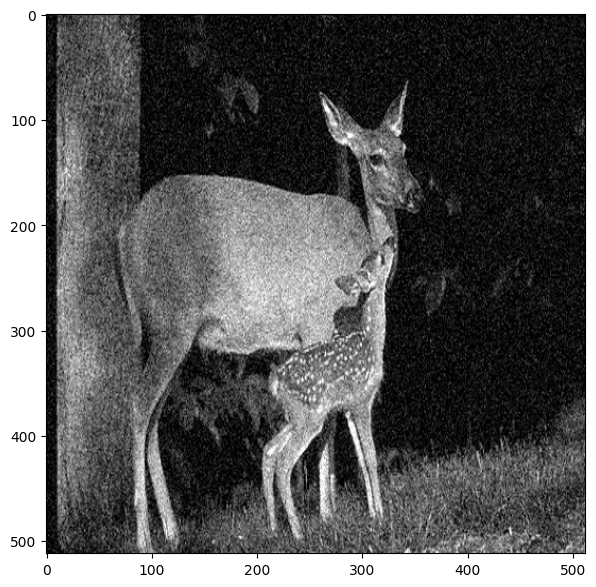

In [2]:
im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
im = im.resize((512, 512))

f = plt.figure()
plt.imshow(im,cmap='gray')

In [3]:
import numpy as np
from scipy.fft import dct, idct

im_gray = np.array(im.convert('L'))

def estimate_noise_level(image, block_size):
    rows, cols = image.shape
    noise_levels = np.zeros((rows//block_size, cols//block_size))
    
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i+block_size, j:j+block_size]
            dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
            high_freq_coeffs = np.abs(dct_block) > 1
            noise_levels[i//block_size, j//block_size] = np.mean(dct_block[high_freq_coeffs])
    
    return noise_levels

print(np.mean(estimate_noise_level(im_gray, 8)))


8.797037095226562


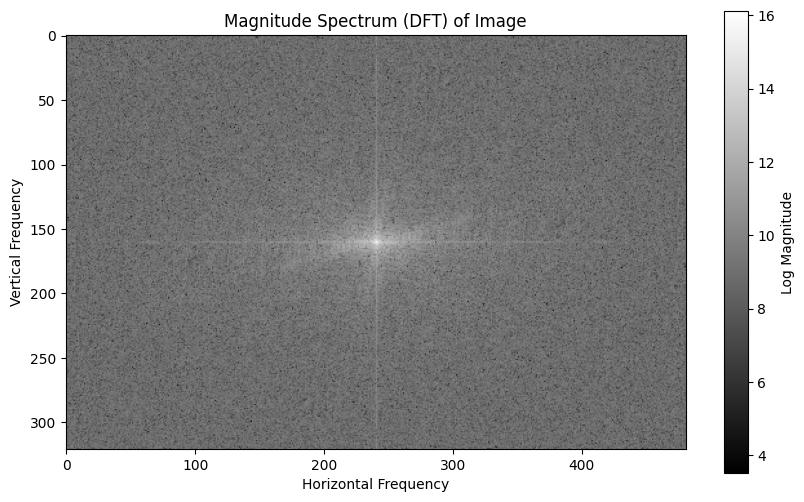

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from PIL import Image

# Load the image
im = Image.open("Figures/noisy_image0_noise_lvl25.jpg")
im = im.resize((512, 512))
image = np.array(Image.open("Figures/noisy_image0_noise_lvl25.jpg").convert('L'))  # Convert to grayscale
# image = image.resize((512, 512))
# Apply 2D DFT to the image
dft_image = fftshift(fft2(image))

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(dft_image)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title('Magnitude Spectrum (DFT) of Image')
plt.xlabel('Horizontal Frequency')
plt.ylabel('Vertical Frequency')
plt.show()

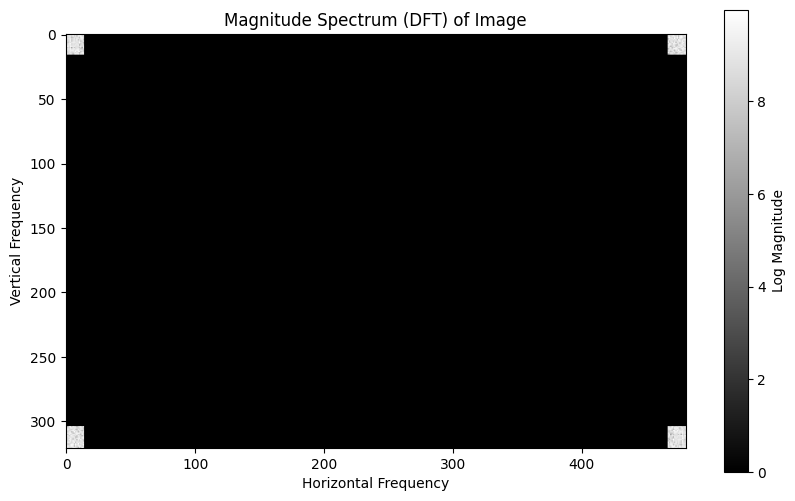

Estimated noise level 47.072233881822996


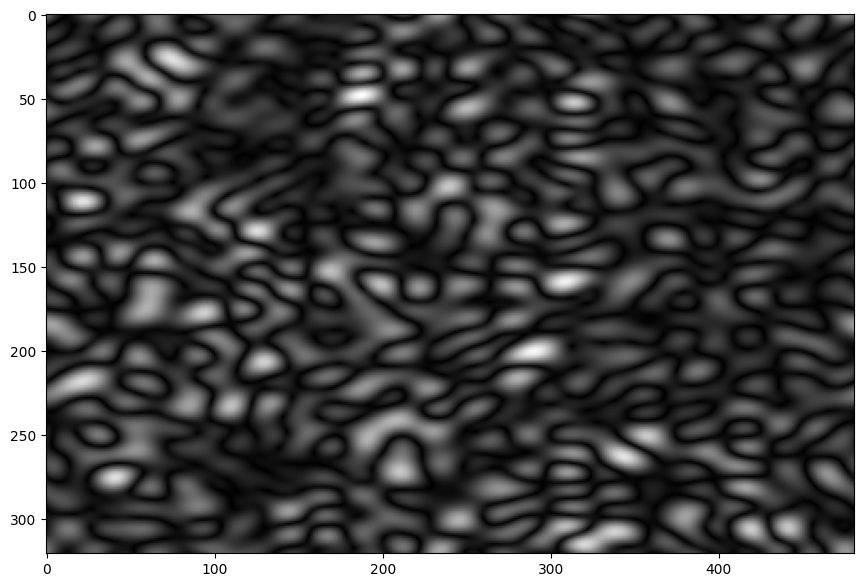

In [5]:
rows, cols = image.shape
center_row, center_col = rows // 2, cols // 2
plus_length = min(rows, cols) // 3  # Adjust the length of the plus shape as needed

length_row = int(0.45*rows)
length_col = int(0.47*cols)

# Create a "plus" shape in the high-pass filter
high_pass_filter = np.ones_like(image)
high_pass_filter[center_row - length_row:center_row + length_row, :] = 0
high_pass_filter[:, center_col - length_col:center_col + length_col] = 0

# Apply the high-pass filter
dft_image_filtered = dft_image * high_pass_filter
magnitude_spectrum = np.abs(dft_image_filtered)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title('Magnitude Spectrum (DFT) of Image')
plt.xlabel('Horizontal Frequency')
plt.ylabel('Vertical Frequency')
plt.show()

# Compute the inverse DFT to obtain the filtered image
filtered_image = np.abs(ifft2(ifftshift(dft_image_filtered)))
plt.imshow(filtered_image,cmap='gray')

noise_level = np.mean(np.abs(dft_image_filtered))
print(f"Estimated noise level {noise_level}")

## Define 2D DCT and IDCT

In [6]:
def dct2(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [7]:
# !pip install pywt
# import pywt

# def wavelet_dct2(a):
#     return pywt.dwt2(a, 'haar')

# def wavelet_idct2(coeffs):
#     return pywt.idwt2(coeffs, 'haar')

In [8]:
def extract_blocks(image, block_size=(8, 8)):
    patches = extract_patches_2d(image, block_size)
    return patches.reshape(patches.shape[0], -1)

## Perform a blockwise DCT

In [9]:
im_gray = np.array(im.convert('L'))
imsize = im_gray.shape

reconstructed_image = np.zeros_like(im_gray, dtype=float)
weights = np.zeros_like(im_gray, dtype=float)

dct = np.zeros(imsize)
thresh = 0.3
blocks = extract_blocks(im_gray)

inverse_patches = []

for i, block in enumerate(blocks):
   
    dct = dct2(block.reshape((8,8)))
    dct_thresh = dct * (abs(dct) > 60)
    inverse_patch = idct2(dct_thresh)
    inverse_patches.append(inverse_patch)
    if i % 5000 == 0:
        print(np.max(np.abs(dct)))
        print(i)
        percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
        print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
reconstructed_image = reconstruct_from_patches_2d(np.array(inverse_patches), (512, 512))

101.37500000000003
0
Keeping only 0.000381% of the DCT coefficients
113.37500000000001
5000
Keeping only 0.000381% of the DCT coefficients
116.37500000000003
10000
Keeping only 0.000381% of the DCT coefficients
188.87500000000003
15000
Keeping only 0.000381% of the DCT coefficients
107.25000000000003
20000
Keeping only 0.000381% of the DCT coefficients
152.87500000000003
25000
Keeping only 0.000381% of the DCT coefficients
146.12500000000003
30000
Keeping only 0.000763% of the DCT coefficients
126.00000000000001
35000
Keeping only 0.000381% of the DCT coefficients
154.375
40000
Keeping only 0.000381% of the DCT coefficients
525.2500000000001
45000
Keeping only 0.000763% of the DCT coefficients
442.12500000000006
50000
Keeping only 0.001907% of the DCT coefficients
86.37500000000001
55000
Keeping only 0.000381% of the DCT coefficients
122.87500000000001
60000
Keeping only 0.000381% of the DCT coefficients
116.5
65000
Keeping only 0.000381% of the DCT coefficients
630.0000000000001
70000

Text(0.5, 1.0, 'Denoised image by DCT thresholding (overlapping patches)')

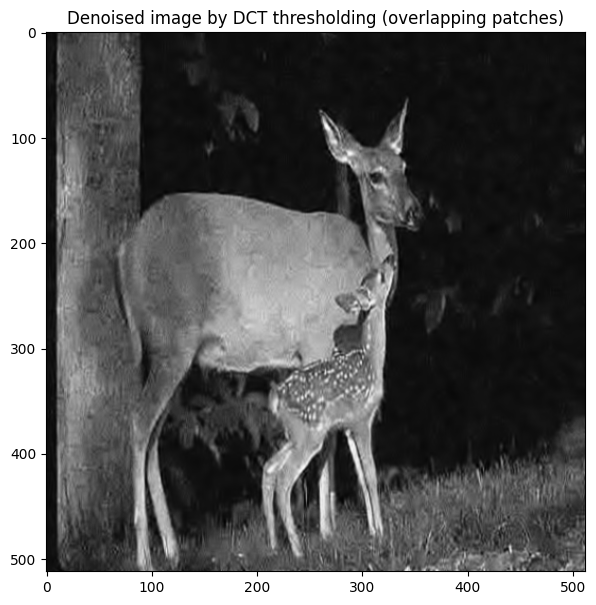

In [10]:
plt.figure()
plt.imshow(reconstructed_image ,cmap='gray')
plt.title("Denoised image by DCT thresholding (overlapping patches)" )

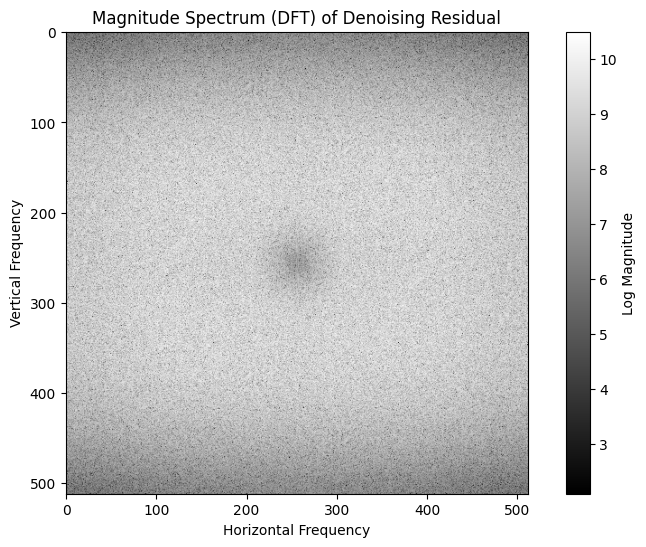

Text(0.5, 1.0, 'Difference between original and DCT compressed images')

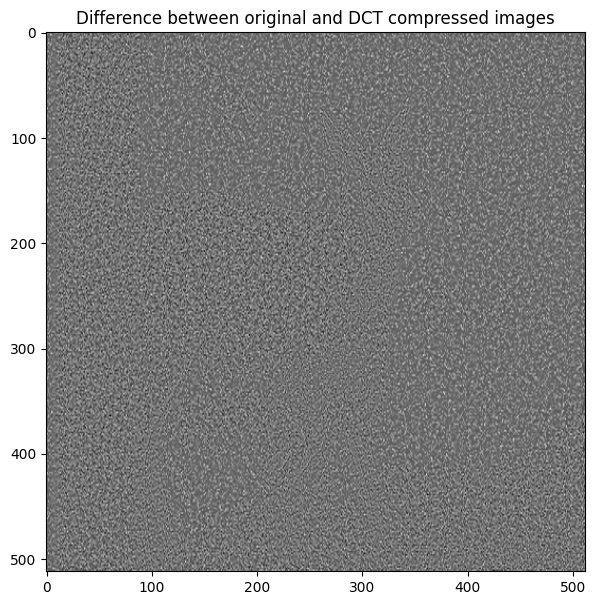

In [11]:
dft_image = fftshift(fft2(im_gray-reconstructed_image))

# Compute the magnitude spectrum
magnitude_spectrum = np.abs(dft_image)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 6))
plt.imshow(np.log(magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title('Magnitude Spectrum (DFT) of Denoising Residual')
plt.xlabel('Horizontal Frequency')
plt.ylabel('Vertical Frequency')
plt.show()

plt.figure()
plt.imshow((im_gray-reconstructed_image) ,cmap='gray')
plt.title("Difference between original and DCT compressed images" )

In [12]:
compute_metrics(im_gray, reconstructed_image)

(14.720338061004702, 24.772447929922606)

In [13]:
im_gray = np.array(im.convert('L'))
imsize = im_gray.shape

reconstructed_image = np.zeros_like(im_gray, dtype=float)
weights = np.zeros_like(im_gray, dtype=float)

dct = np.zeros(imsize)
thresh = 0.0
blocks = extract_blocks(im_gray)

for i, block in enumerate(blocks):
    print(i)
    dct = dct2(block.reshape((8,8)))
    dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))
    inverse_patch = idct2(dct_thresh)
    # TODO: aggregate all inverse patches, average them and reconstruct the original image 
    # Reshape and update the reconstructed image and weights
    row_idx = (i) // im_gray.shape[1]
    col_idx = (i) % im_gray.shape[1]

    if (row_idx > imsize[0]-8) or (col_idx > imsize[1]-8):
        continue
    # print(f"{row_idx=}; {row_idx+8=}; {col_idx=}; {col_idx+8=}; {inverse_patch.shape=}")
    reconstructed_image[row_idx:row_idx+8, col_idx:col_idx+8] += inverse_patch
    weights[row_idx:row_idx+8, col_idx:col_idx+8] += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Performance metrics

In [14]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from utils import normalize_image, compute_metrics

noisy_image = cv2.imread("Figures/noisy_image0_noise_lvl25.jpg", cv2.IMREAD_GRAYSCALE)
clean_image = cv2.imread("Figures/image2.jpg", cv2.IMREAD_GRAYSCALE)
 

reconstructed_image = normalize_image(reconstructed_image)

## Other techniques

In [15]:
im_gray = np.array(im.convert('L'))
imsize = im_gray.shape

dct = np.zeros(imsize)

# Do 8x8 DCT on image (in-place)
for i in np.r_[:imsize[0]:8]:
    for j in np.r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2( im_gray[i:(i+8),j:(j+8)] )

## Extract 8x8 block and look at its DCT coefficients

Text(0.5, 1.0, 'An 8x8 DCT block')

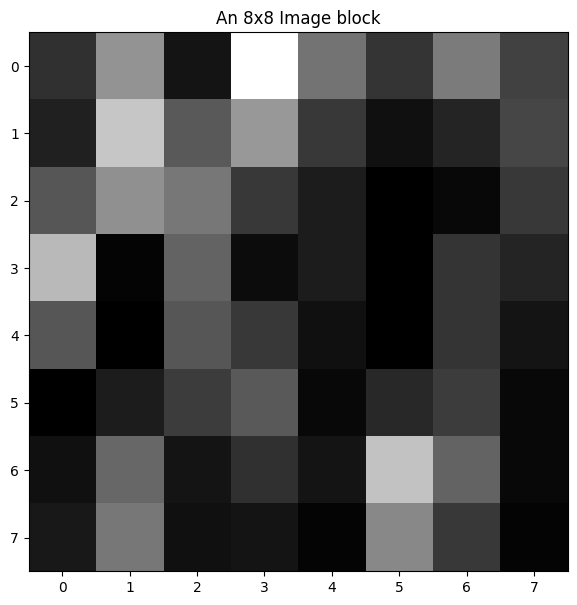

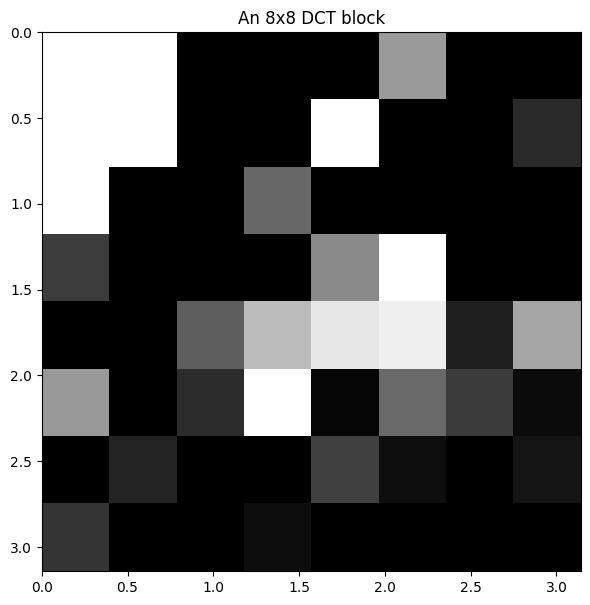

In [16]:
pos = 128

# Extract a block from image
plt.figure()
plt.imshow(im_gray[pos:pos+8,pos:pos+8],cmap='gray')
plt.title( "An 8x8 Image block")

# Display the dct of that block
plt.figure()
plt.imshow(dct[pos:pos+8,pos:pos+8],cmap='gray',vmax= np.max(dct)*0.01,vmin = 0, extent=[0,pi,pi,0])
plt.title( "An 8x8 DCT block")

## Display all DCT blocks

Text(0.5, 1.0, '8x8 DCTs of the image')

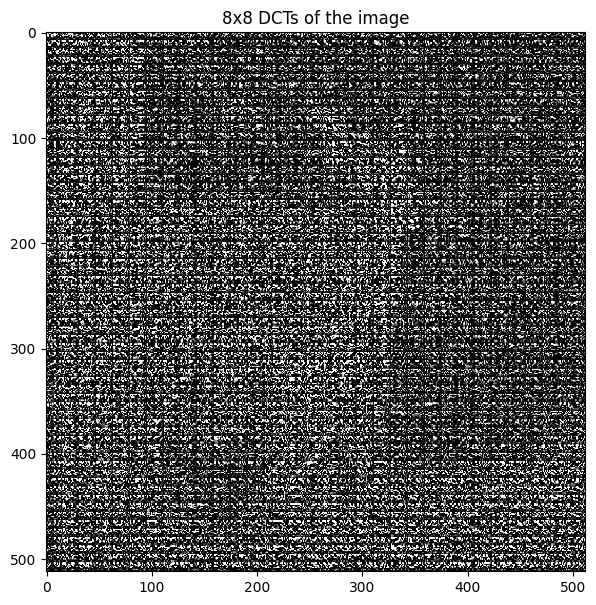

In [17]:
plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "8x8 DCTs of the image")

## Threshold DCT coefficients

Keeping only 10.250092% of the DCT coefficients


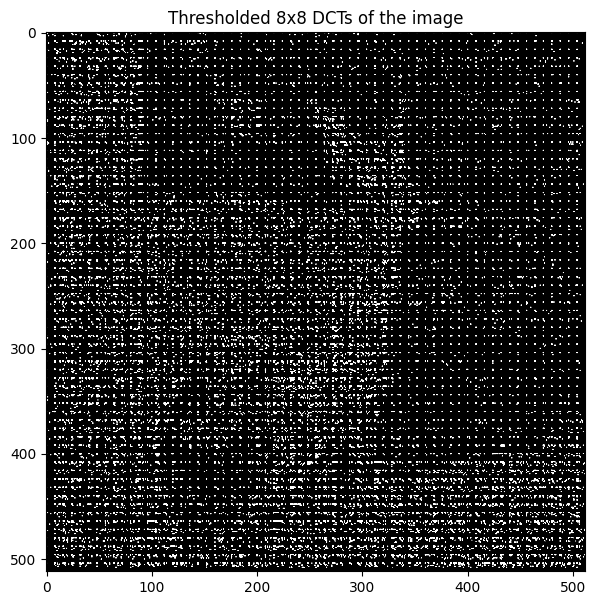

In [18]:

# Threshold
thresh = 0.022
dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))


plt.figure()
plt.imshow(dct_thresh,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Thresholded 8x8 DCTs of the image")

percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)

print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))

## Compare DCT compressed image with original (Non overlapping patches)

Text(0.5, 1.0, 'Comparison between original and DCT compressed images')

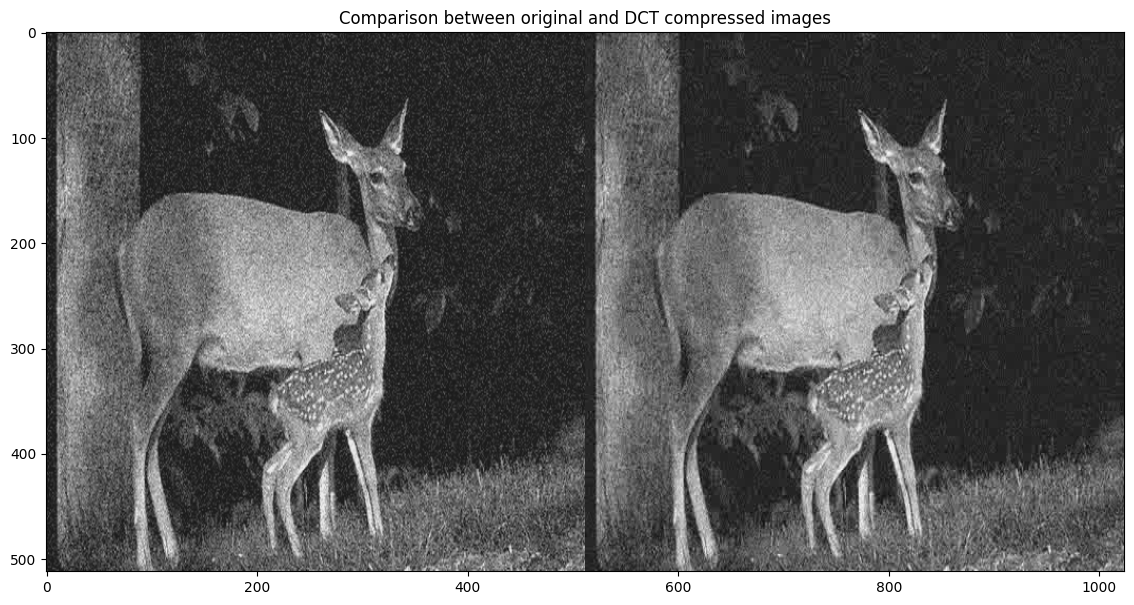

In [19]:

im_dct = np.zeros(imsize)

for i in np.r_[:imsize[0]:8]:
    for j in np.r_[:imsize[1]:8]:
        im_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )
        
        
plt.figure()
plt.imshow( np.hstack( (im_gray, im_dct) ) ,cmap='gray')
plt.title("Comparison between original and DCT compressed images" )

In [20]:
rmse, pnsr = compute_metrics(im_gray, im_dct)   
print(f"RMSE: {rmse}")
print(f"PSNR: {pnsr}")

RMSE: 12.659756681785792
PSNR: 26.082296434662595
